# StackOverflow Basic Text Classification

This notebook demonstrates text classifcation starting from plain text files store on disk. We'll train a multi-class classifier to peform sentiment analysis on StackOverflow dataset.

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
print(tf.__version__)

2.10.1


## Sentiment analysis
This notebook trains a sentiment analysis model to classify the tags for a programming question on Stack Overflow based on the text of the question. This is an example of multi-class classification, an important and widely applicable kind of machine learning problem.
</br></br>
We'll use the Stack Overflow questions dataset that contains the text of 16,000 programming questions from the Stack Overflow. These are split into 8000 questions for training and 8000 question for testing. The training and testing sets are balanced, meaning they contain an equal number of question for each programming language.

## Explore the dataset
Let's extract the dataset the explore the directory structure

In [2]:
dataset_dir=os.path.join(os.path.dirname('./'),'data')

In [3]:
os.listdir(dataset_dir)

['README.md', 'test', 'train']

In [4]:
train_dir=os.path.join(dataset_dir,'train')
os.listdir(train_dir)

['csharp', 'java', 'javascript', 'python']

The `data/train` and `data/test` directories contain many text files, each of which is a single programming questions. Lets' take a look at one of them

In [5]:
sample_file=os.path.join(train_dir,'csharp/0.txt')
with open(sample_file) as f:
    print(f.read())

"how to pause loop while time is ticking i have made a timer where i can set time i want to wait and then do something..so this is my short timer func:..private void sleep(int interval, action action).{.    system.windows.forms.timer mytimer = new system.windows.forms.timer();.    mytimer.interval = interval; //interval is in ms   .    mytimer.start();.    mytimer.tick += (s, e) =&gt;.    {.        action();.        mytimer.stop();.    };.}...and im using this timer in loop:..foreach (string word in words).{.   sleep(5000, ()=&gt; myaction());                                           .}...without loop timer is great but in loop it wont work because loop wont stop and wait for those 5secs. it do all stuff imediately and starts timer again and again too fast...so what im trying to find out is how to make my loop wait until time runs out and myaction() is executed. im working on forms application so all threadin sleeps wont work here. also i tried all other timers but they used too much 

## Load the dataset
We will load the data off disk and prepare it into a format suitable for training. To do so, we will use the `text_dataaset_from_directory`
</br></br>
To prepare a dataset for multi-class classification, we will need four folder on disk, corresponding to differenct programming language. This can be found in `data/train/csharp`, `data/train/java`, `data/train/javascript` and `data/train/python`.
</br></br>
Next, we will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`. `tf.data` is a powerful collection of tools for working with data.
</br></br>
When running a machine learning experiment it is a best practice to divide our dataset into threes splits: `train`, `validation`, `test`.
</br></br>
The Stack Overflow questions dataset has alreadt been divided into train and test, but it lacks a validation set. Let's create a validation set using 80:20 split of the training data by using the `validation_split` argument.

In [6]:
batch_size=32
seed=42

raw_train_ds=tf.keras.utils.text_dataset_from_directory(
    'data/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


As we can see above, there are 8000 examples in the training folder, of which we will use 80% (or 6400) for training.
</br></br>
We can also iterate over the dataset and print out a few examples to see the sample questions.

In [7]:
for text_batch,label_batch in raw_train_ds.take(1):
    for i in range(10):
        print("Question ",text_batch.numpy()[i])
        print("Language ",label_batch.numpy()[i])

Question  b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default cons

These labels are 0 to 3. To see which of these correspond to which programming language, we can check the `class_names` property on the dataset

In [8]:
print("Language 0 corresponds to",raw_train_ds.class_names[0])
print("Language 1 corresponds to",raw_train_ds.class_names[1])
print("Language 2 corresponds to",raw_train_ds.class_names[2])
print("Language 3 corresponds to",raw_train_ds.class_names[3])

Language 0 corresponds to csharp
Language 1 corresponds to java
Language 2 corresponds to javascript
Language 3 corresponds to python


Next, we will create a validation and test dataset. We will use the remaining 1600 reviews from the training set for validation

In [9]:
raw_val_ds=tf.keras.utils.text_dataset_from_directory(
    'data/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [10]:
raw_test_ds=tf.keras.utils.text_dataset_from_directory(
    'data/test',
    batch_size=batch_size
)

Found 8000 files belonging to 4 classes.


## Prepare the dataset for training

Next, we will **standardize**, **tokenize** and **vectorize** the data using the `tf.keras.layers.TextVectorization` layer.
</br></br>
**Standardization** refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify dataset.</br> 
**Tokenization** refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace).</br>
Vectorization refers to converting tokens into numbers so they can be fed into a neural network.</br>
All of these tasks can be accomplished with this layer.
</br></br>
As we saw above, the reviews contain various HTML tags like `<br />`. These tags will not be removed by the default standardizer in the TextVectorization layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

In [11]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, we will create `TextVectorization` layer. We will use this layer to standardize, tokenize, and vectorize our data. We set the `output_mode` to `int` to create unique integer indices for each token.
</br></br>
We are using the default split function and the custom standardization function we defined above. We'll also define some constants for the model, like an explicit maxinunm `sequence_length`, which will cause the layer to pad or truncate sequences to exactly `sequence_length` values.

In [12]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Next, we will call `adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build and index of strings to integers.

In [13]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Create a function to see the result of using this layer to preprocess some data.

In [14]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [15]:
text_batch,label_batch=next(iter(raw_train_ds))
first_question,first_language=text_batch[0],label_batch[0]
print("Question: ",first_question)
print("Language: ",raw_train_ds.class_names[first_language])
print("Vectorized questions: ",vectorize_text(first_question,first_language))

Question:  tf.Tensor(b'"set blank to quit on exception? i\'m using blank 3..i\'ve been looking around for an answer to this, but i haven\'t found it yet. basically, i\'m running several blank scripts into a game engine, and each script has its own entry point...i\'d rather not add try: except blocks through all of my code, so i was wondering if it\'s at all possible to tell blank to quit (or perhaps assign a custom function to that ""callback"") on finding its first error, regardless of where or what it found? ..currently, the game engine will continue after finding and hitting an error, making it more difficult than necessary to diagnose issues since running into one error may make a subsequent script not work (as it relies on variables that the error-ing script set, for example). any ideas? ..i know that i could redirect the console to a file to allow for easier scrolling, but just capturing the first error and stopping the game prematurely would be really useful...okay, a couple of 

As we can see above, eack token has been replaced by an integer. We can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer.

In [16]:
print("1314 ---> ",vectorize_layer.get_vocabulary()[1314])
print("1111 ---> ",vectorize_layer.get_vocabulary()[1111])
print("Vocabulary size: {}".format(len(vectorize_layer.get_vocabulary())))

1314 --->  magic
1111 --->  comma
Vocabulary size: 10000


As a final preprocessing steps, we will apply the TextVectorization layer we created earlier to the train, validation and the test dataset.

In [17]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

## Configure the dataset for performance
These are two important method we should use when loading data to make sure that I/O does not become blocking.
</br></br>
`.cache()` keepds data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training model. If the dataset is too large to fit into memory, we can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.
</br></br>
`.prefetch()` overlaps data preprocessing and model execution while training

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the model

In [19]:
embedding_dim=16

In [20]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 4)                 68        
                                                                 
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
__________________________________________________

The layers stacked sequentially to build the classifier:
1. The first layer is an `Embedding` layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimension are : `(batch, sequence, embedding)`
1. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest wat possible.
1. The last layer is densely conencted to 4 node as there are four output classes.

## Loss function and optimizer.

A model needs a loss function and optimizer for training. Since this is a multi-class classification problem and the model outputs a probability for four classes, we'lll use `losses.SparseCategoricalCrossentropy` loss function

In [21]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

## Train the model
Train the model by passing the `dataset` object to the fit method

In [22]:
epochs=30
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/30
200/200 [==============================] - 7s 21ms/step - loss: 1.3785 - accuracy: 0.3348 - val_loss: 1.3666 - val_accuracy: 0.5019
Epoch 2/30
200/200 [==============================] - 1s 5ms/step - loss: 1.3494 - accuracy: 0.4495 - val_loss: 1.3293 - val_accuracy: 0.5531
Epoch 3/30
200/200 [==============================] - 1s 4ms/step - loss: 1.3019 - accuracy: 0.5378 - val_loss: 1.2732 - val_accuracy: 0.6006
Epoch 4/30
200/200 [==============================] - 1s 4ms/step - loss: 1.2355 - accuracy: 0.5939 - val_loss: 1.2019 - val_accuracy: 0.6413
Epoch 5/30
200/200 [==============================] - 1s 4ms/step - loss: 1.1590 - accuracy: 0.6477 - val_loss: 1.1265 - val_accuracy: 0.6800
Epoch 6/30
200/200 [==============================] - 1s 4ms/step - loss: 1.0805 - accuracy: 0.6880 - val_loss: 1.0535 - val_accuracy: 0.7125
Epoch 7/30
200/200 [==============================] - 1s 4ms/step - loss: 1.0069 - accuracy: 0.7186 - val_loss: 0.9877 - val_accuracy: 0.7331
Epoch

## Evaluate the model
Two values will be returned. Loss (a number which represents our model error, lower values are better) and accuracy

In [23]:
loss,accuracy=model.evaluate(test_ds)

print("Loss:",loss)
print("Accuracy:",accuracy)

250/250 [==============================] - 15s 57ms/step - loss: 0.5588 - accuracy: 0.7980
Loss: 0.5587634444236755
Accuracy: 0.7979999780654907


This fairly naive approach achieves an accuracy of about 80%

## Create a plot of accuracy and loss over time
`model.fit()` return a `History` object that contains a dictionary with everything that happened during training:

In [24]:
history_dict=history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

There are four entries: one for each monitored metric during training and validation. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy.

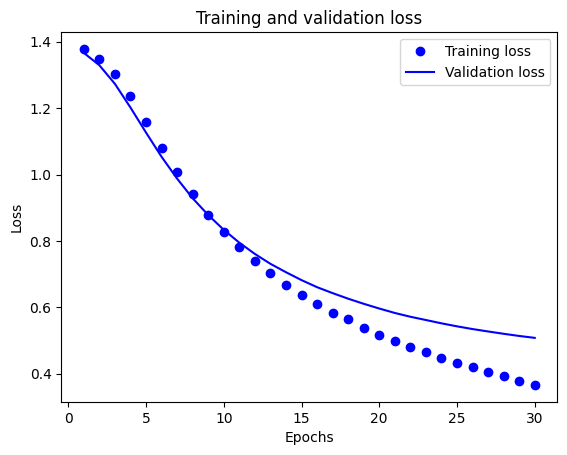

In [25]:
acc=history_dict['accuracy']
val_acc=history_dict['val_accuracy']
loss=history_dict['loss']
val_loss=history_dict['val_loss']

epochs=range(1,len(acc)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

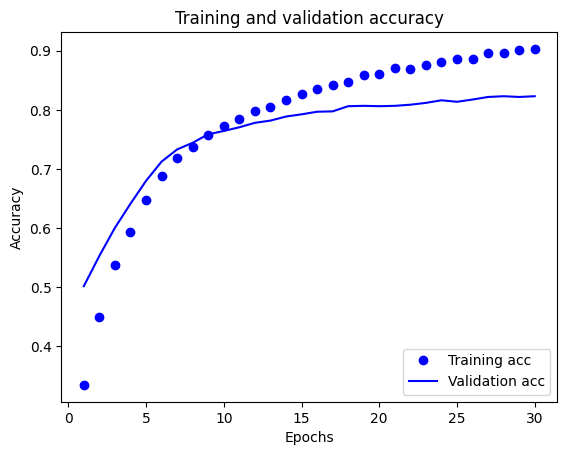

In [26]:
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'b',label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.
</br></br>
Notice the training loss decreases with each epoch and the training accuracy increases with each epochs. This is expected when using a gradient descent optimization - it should minimize the desired quantity on every iteration.
</br></br>
This isnt't the case for the validation loss and accuracy - they seem to peak the training accuracy. This is an example of overfitting: the model performs better on the training data than it does ont data it has never seen before. After this point, the model over-optimizes and learns representation specific to the training data that do no generalize to test data.
</br></br>
For this particular case, we could prevent overfitting by simply stopping the training with the validation accuracy is no longer increasing. One way to do is to use the `tf.keras.callbacks.EarlyStopping` callback.

## Export the model
In the code above, we applied the `TextVectorization` layer to the dataset before feeding text to the model. If we want to make our model capable of processing raw strings (for example, to simplifty deploying it), we can include the `TextVectorization` layer inside out model. To do so, we can create a new model using the weights we just trained.

In [27]:
export_model=tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False),optimizer='adam',metrics=['accuracy']
)

loss,accuracy=export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 3s 9ms/step - loss: 0.5588 - accuracy: 0.7980
0.7979999780654907


## Inference of new data
To get predictions for new examples, we can simply call `model.predict()`

In [28]:
example=[
    'pandas how to get first column',
    'jpanel how to add jbutton',
    'getElementById',
]
export_model.predict(example)

1/1 [==============================] - 0s 135ms/step


array([[0.56439084, 0.42297718, 0.51101536, 0.5116522 ],
       [0.5212615 , 0.56894505, 0.5258821 , 0.40572682],
       [0.5357643 , 0.4615377 , 0.5777653 , 0.43604615]], dtype=float32)

Including the text preprocessing login inside model enables usto export a model for production that simplifies deployment, and reduces the potential for **train/test skew**
</br></br>
There is a performance difference to keep in mind when choosing where to apply our TextVectorization layer. Using it outside of our mode enables our to do asyncchronous CPU processing and buffering on our data when training on GPU. So, if we're trianing our model on GPU, we probably want to go with this option to get the best performance while developing our model, then switch to including the TextVectorization layer inside our model when we're ready to prepare for deployment.